<a href="https://colab.research.google.com/github/rim-yu/SGU_ANT6320_Assignment/blob/master/Exercise04_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
cd /root/.fastai/data/camvid/labels

/root/.fastai/data/camvid/labels


In [0]:
ls

In [7]:
cd /root/.fastai/data/camvid/images

/root/.fastai/data/camvid/images


In [0]:
ls

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [9]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04530.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_009420.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f02520.png')]

In [10]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_08107_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01140_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03780_P.png')]

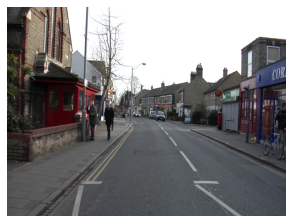

In [17]:
img_f = fnames[0] # img_f = PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04530.png')
img = open_image(img_f) # open_image(PosixPath('파일 경로')) command를 통해 이미지로 변환할 수 있다. 
img.show(figsize=(5,5)) # show command로 figure의 size를 조절하기 위함. 

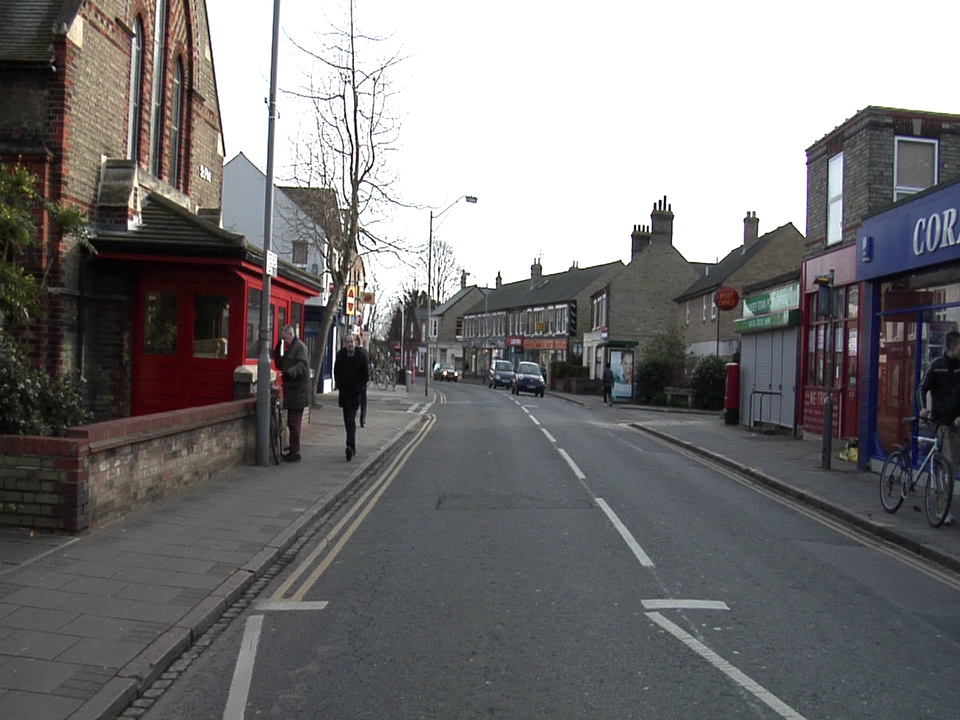

In [12]:
img

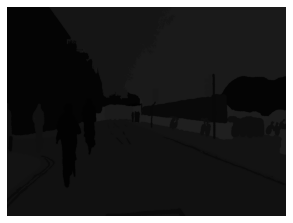

In [21]:
test_img_f = lbl_names[0]
test_img = open_image(test_img_f)
test_img.show(figsize=(5,5))
# labels folder 내의 file들은 black 계열의 색상으로 구분되어있다.  



> **.stem**


PurePosixPath('my/library.tar.gz').stem

output : 'library.tar'

PurePosixPath('my/library.tar').stem

output : 'library'

PurePosixPath('my/library').stem
output : 'library'


> **.suffix**

PurePosixPath('my/library/setup.py').suffix

output : '.py'

PurePosixPath('my/library.tar.gz').suffix

output : '.gz'

PurePosixPath('my/library').suffix

output : ''

**they come from python’s pathlib library** 

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
# /root/.fastai/data/camvid/labels/0016E5_08107_P.png
# [imageFileName]_P.[imageExtension]

In [43]:
get_y_fn(img_f)

PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04530_P.png')

In [39]:
import pathlib
test_path = Path("/root/.fastai/data/camvid/labels/0016E5_08107_P.png")
print("if i used .stem : ", test_path.stem)
print("if i used .suffix : ", test_path.suffix)

test_lambda = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
test_lambda(test_path)

if i used .stem :  0016E5_08107_P
if i used .suffix :  .png


PosixPath('/root/.fastai/data/camvid/labels/0016E5_08107_P_P.png')

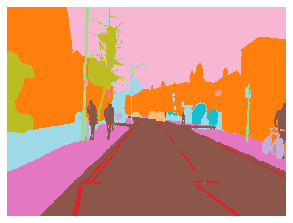

In [32]:
mask = open_mask(get_y_fn(img_f)) 
mask.show(figsize=(5,5), alpha=1)
# open_img로 열 수 있지만 우리가 얻고 싶은 것은 정수값이었음. 그래서 open_mask 사용함. 자동으로 색상도 지정함. 

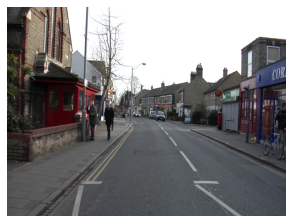

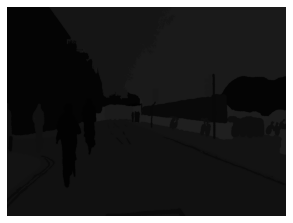

In [47]:
img.show(figsize=(5,5)) # 이 이미지를 통해 mask를 여는 것임. 
test_img.show(figsize=(5,5)) # 라벨에 있는 이미지. 

In [52]:
src_size = np.array(mask.shape[1:]) # 720*960 array. 
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [53]:
mask.shape
# 사실 마스크는 3차원 array임. 

torch.Size([1, 720, 960])

In [56]:
mask.size

torch.Size([720, 960])

In [70]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [73]:
size = src_size//2 # 2로 나눌 때 //2로 하면 값이 int로 반환됨. /2로 하면 float으로 나옴. 
# size는 array([360, 480])

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       # ItemList suitable for segmentation tasks. 자동으로 mask를 생성하는 것 같음. 
       .split_by_fname_file('../valid.txt') 
       # valid.txt file은 camvid folder 아래 위치해있음. 
       # ../할 경우 camvid folder를 지칭하는 건가.? 
       # 무작위로 valid dataset를 선정하지 않는다고 했음. valid.txt를 통해 valid dataset 목록을 제공함.  
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [76]:
path_img

PosixPath('/root/.fastai/data/camvid/images')



> valid.txt


0016E5_07959.png
0016E5_07961.png
0016E5_07963.png
0016E5_07965.png
0016E5_07967.png
0016E5_07969.png
0016E5_07971.png
0016E5_07973.png
0016E5_07975.png
0016E5_07977.png
0016E5_07979.png
0016E5_07981.png
0016E5_07983.png
0016E5_07985.png
0016E5_07987.png
0016E5_07989.png
0016E5_07991.png
0016E5_07993.png
0016E5_07995.png
0016E5_07997.png
0016E5_07999.png
0016E5_08001.png
0016E5_08003.png
0016E5_08005.png
0016E5_08007.png
0016E5_08009.png
0016E5_08011.png
0016E5_08013.png
0016E5_08015.png
0016E5_08017.png
0016E5_08019.png
0016E5_08021.png
0016E5_08023.png
0016E5_08025.png
0016E5_08027.png
0016E5_08029.png
0016E5_08031.png
0016E5_08033.png
0016E5_08035.png
0016E5_08037.png
0016E5_08039.png
0016E5_08041.png
0016E5_08043.png
0016E5_08045.png
0016E5_08047.png
0016E5_08049.png
0016E5_08051.png
0016E5_08053.png
0016E5_08055.png
0016E5_08057.png
0016E5_08059.png
0016E5_08061.png
0016E5_08063.png
0016E5_08065.png
0016E5_08067.png
0016E5_08069.png
0016E5_08071.png
0016E5_08073.png
0016E5_08075.png
0016E5_08077.png
0016E5_08079.png
0016E5_08081.png
0016E5_08083.png
0016E5_08085.png
0016E5_08087.png
0016E5_08089.png
0016E5_08091.png
0016E5_08093.png
0016E5_08095.png
0016E5_08097.png
0016E5_08099.png
0016E5_08101.png
0016E5_08103.png
0016E5_08105.png
0016E5_08107.png
0016E5_08109.png
0016E5_08111.png
0016E5_08113.png
0016E5_08115.png
0016E5_08117.png
0016E5_08119.png
0016E5_08121.png
0016E5_08123.png
0016E5_08125.png
0016E5_08127.png
0016E5_08129.png
0016E5_08131.png
0016E5_08133.png
0016E5_08135.png
0016E5_08137.png
0016E5_08139.png
0016E5_08141.png
0016E5_08143.png
0016E5_08145.png
0016E5_08147.png
0016E5_08149.png
0016E5_08151.png
0016E5_08153.png
0016E5_08155.png
0016E5_08157.png
0016E5_08159.png

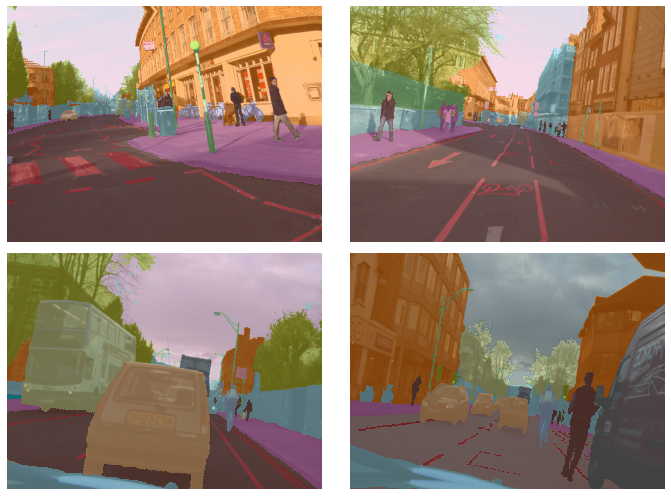

In [89]:
data.show_batch(2, figsize=(10,7))

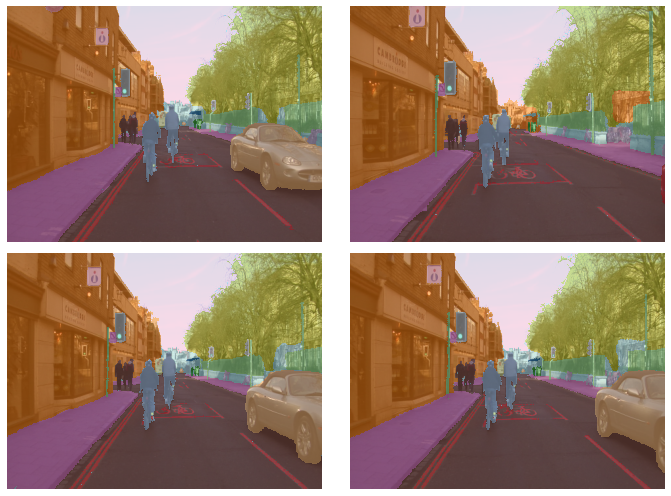

In [90]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
# enumerate는 열거한다는 뜻으로 list의 원소 순서와 원소 값, 2개를 동시에 반환한다. 
void_code = name2id['Void']

def acc_camvid(input, target): # 표준 정확도일 뿐임. 
    target = target.squeeze(1) # squeeze 함수는 차원을 축소함. 
    mask = target != void_code # target이 void_code가 아닐 경우 mask를 만든다. 
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean() 

# argmax는 f(x)를 최대값으로 만드는 x값을 말한다. 

In [104]:
test_arr = np.array([[[[1,2,3,4,5,6,7]]]])
test_arr.squeeze(1)
# squeeze()를 할 경우 array 전체를 1차원으로 축소하고, squeeze(1)를 할 경우 전체 차원 중 한 차원만 축소함. 

array([[[1, 2, 3, 4, 5, 6, 7]]])

In [109]:
test_matrix = np.array([[[1,2,3,4],
                         [4,5,6,7],
                         [8,9,10,11]],
                        [[1,2,3,4],
                         [4,5,6,7],
                         [8,9,10,11]]])
test_matrix.shape

(2, 3, 4)

In [92]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2
# weight decay(가중치 감소) : 학습 과정에서 큰 가중치에 대해서 그에 상응하는 큰 패널티를 부과하여 과대적합을 억제. 
# Regularization(규제)를 적용하여 출력에 주는 영향을 최소가 되게 함. 
# 가중치 절댓값을 작게(0에 가깝게) 만드는 것으로 L1 규제와 L2 규제가 있음. 

In [113]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth




> **Unet**


Unet은 의료 영상/이미지 segmentation에서 많이 쓰이는 모델 구조의 시초라고 한다. segmentation이란 컴퓨터 비전 분야에서 핵심적인 기술 중에 하나이다. 배경과 객체를 분할하는 기술이라고 보면된다. Unet은 속도가 빠르고 Patch의 사이즈에 따른 trade off에 빠지지 않는다. 최종적으로 흑백 이미지를 컬러 이미지로 복원할 수 있을 것이다. 

In [112]:
doc(unet_learner)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


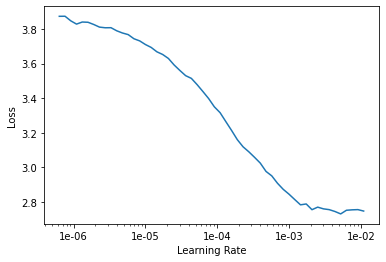

In [114]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [116]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.200936,0.809241,0.806211,00:57
1,0.808248,0.582583,0.845754,00:54
2,0.723173,0.650720,0.837036,00:53
3,0.647889,0.563144,0.857438,00:54
4,0.599339,0.517156,0.858692,00:52
5,0.599259,0.538074,0.851190,00:53
6,0.548829,0.485342,0.872768,00:52
7,0.608129,0.476359,0.871127,00:52
8,0.573007,0.423356,0.880080,00:51
9,0.472297,0.345975,0.901185,00:53


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

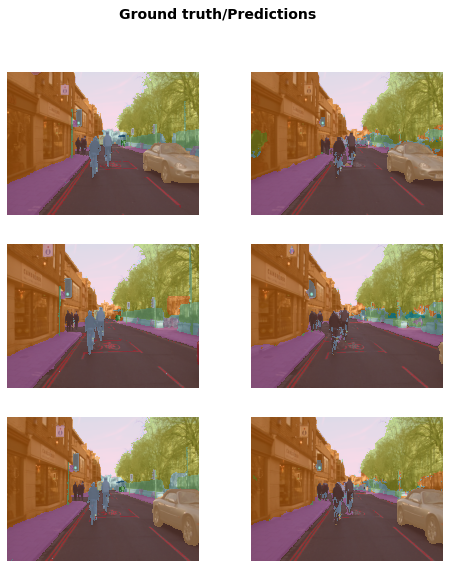

In [119]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [122]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.406035,0.346353,0.897930,00:54
1,0.397147,0.341365,0.899602,00:54
2,0.382171,0.333189,0.903862,00:55
3,0.367468,0.326384,0.905861,00:55
4,0.362050,0.336715,0.907934,00:55
5,0.351363,0.303371,0.918102,00:54
6,0.339548,0.300113,0.914277,00:55
7,0.324685,0.290583,0.920403,00:55
8,0.315597,0.308867,0.914646,00:55
9,0.303644,0.296161,0.916862,00:55


In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [124]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15559MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


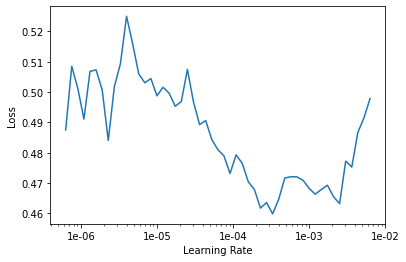

In [128]:
lr_find(learn)
learn.recorder.plot()



> Discriminative Learning Rate

fit_one_cycle을 부를 때 max_lr의 값으로 숫자를 넘기는 게 아닌 slice method로 그 값의 범위를 넘겨주고 있음. max_lr의 값으로 slice method를 통해 범위를 지정해주면 모델을 이루는 각 레이어에 적용되는 학습률을 범위 안의 값을 점진적으로 할당하게 됨. 예를 들어 slice(1e-06, 1e-04)는 데이터가 인풋으로 들어가는 가장 첫 레이어에 1e-06의 학습률을, 마지막 출력 레이어에 1e-04의 학습률을, 그 사이의 레이어들은 순차적으로 1e-06부터 1e-04 사이의 값을 차례로 할당하게 된다. Discriminative Learning Rate로 소개된 학습률 할당 방식은 성능이 월등히 뛰어남. 서로 다른 도메인의 문제를 이미 학습된 하나의 모델을 조정(fine tuning)하는 과정에서 매우 짧은 시간, 적은 데이터로도 높은 성능을 낼 수 있게 도와준다. 

In [0]:
lr=1e-3

In [130]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.384043,0.312835,0.916529,03:37
1,0.350986,0.291354,0.921687,03:34
2,0.328418,0.306641,0.917220,03:34
3,0.328991,0.277499,0.925420,03:34
4,0.323214,0.269162,0.925358,03:34
5,0.326814,0.310067,0.917276,03:34
6,0.309163,0.266360,0.926225,03:34
7,0.319923,0.375239,0.913866,03:34
8,0.285618,0.246531,0.936372,03:34
9,0.239694,0.242929,0.934498,03:34


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

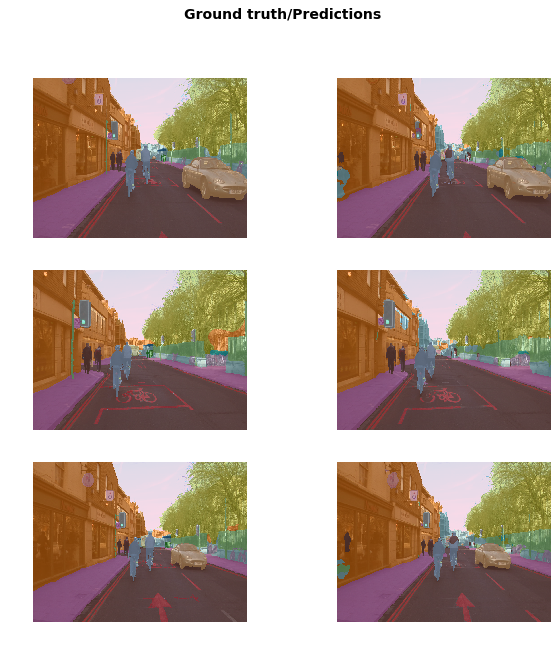

In [0]:
learn.show_results(rows=3, figsize=(10,10))

## fin